In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## **Loading dataset**



In [2]:
from torchvision import datasets, transforms
use_cuda = True

device = torch.device("cuda" if use_cuda else "cpu")

train_batch_size=64
test_batch_size=1000

transform = transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('data', train=True, download=True, transform=transform),
                    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('data', train=False, transform=transform),
                    batch_size=test_batch_size, shuffle=True, **kwargs)

visualize_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])),
                    batch_size=train_batch_size, shuffle=True, **kwargs)

  0%|          | 16384/26421880 [00:00<02:51, 153742.41it/s]

26427392it [00:00, 63878897.81it/s]                            


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


32768it [00:00, 423645.13it/s]
  2%|▏         | 98304/4422102 [00:00<00:04, 976993.98it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


4423680it [00:00, 22322094.30it/s]                         
8192it [00:00, 157912.64it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw
Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


## **Visualize some images**

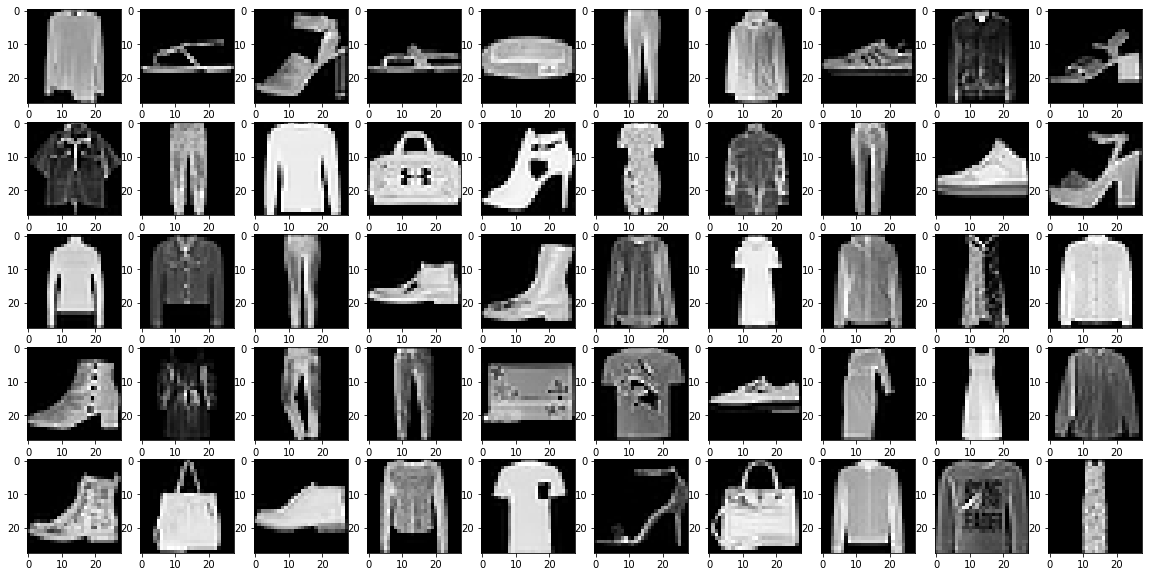

In [3]:
# visualize data
fig=plt.figure(figsize=(20, 10))
data, label = next(iter(visualize_loader))
for i in range(1, 51):
    img = data[i][0]
    fig.add_subplot(5, 10, i)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.show()

## **Model definition**

In [0]:
# First model
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(784, 10)

#     def forward(self, x):
#         x = x.view(-1, 784)
#         x = self.fc1(x)
#         return F.log_softmax(x, dim=1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.bnm1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.bnm2 = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.bnm1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.bnm2(x)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## **Optimizer**

In [0]:
import torch.optim as optim

lr=0.01
momentum = 0.5

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

## **Functions for train and test model**

In [0]:
def train(model, device, train_loader, optimizer, epoch,log_interval):
    model.train()
    avg_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # zero the gradient buffers
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step() # Does the update
        avg_loss+=F.nll_loss(output, target, reduction='sum').item()
        
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{:5.0f}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
    avg_loss/=len(train_loader.dataset)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    accuracy = 100. * correct / len(test_loader.dataset)
    time.sleep(0.2)
    return test_loss,accuracy

## **Training model**

In [0]:
epochs = 5
log_interval = 47
save_model = False

In [29]:
train_losses = []
test_losses = []
accuracy_list = []
for epoch in range(1, epochs + 1):
    trn_loss = train(model, device, train_loader, optimizer, epoch,log_interval)
    test_loss,accuracy = test(model, device, test_loader)
    train_losses.append(trn_loss)
    test_losses.append(test_loss)
    accuracy_list.append(accuracy)

if (save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [    0/60000 (0%)]	Loss: 2.339401
Train Epoch: 1 [ 3008/60000 (5%)]	Loss: 0.749278
Train Epoch: 1 [ 6016/60000 (10%)]	Loss: 0.654954
Train Epoch: 1 [ 9024/60000 (15%)]	Loss: 0.506254
Train Epoch: 1 [12032/60000 (20%)]	Loss: 0.436791
Train Epoch: 1 [15040/60000 (25%)]	Loss: 0.452810
Train Epoch: 1 [18048/60000 (30%)]	Loss: 0.554924
Train Epoch: 1 [21056/60000 (35%)]	Loss: 0.573042
Train Epoch: 1 [24064/60000 (40%)]	Loss: 0.263473
Train Epoch: 1 [27072/60000 (45%)]	Loss: 0.373467
Train Epoch: 1 [30080/60000 (50%)]	Loss: 0.406803
Train Epoch: 1 [33088/60000 (55%)]	Loss: 0.338499
Train Epoch: 1 [36096/60000 (60%)]	Loss: 0.418622
Train Epoch: 1 [39104/60000 (65%)]	Loss: 0.345753
Train Epoch: 1 [42112/60000 (70%)]	Loss: 0.249012
Train Epoch: 1 [45120/60000 (75%)]	Loss: 0.314582
Train Epoch: 1 [48128/60000 (80%)]	Loss: 0.287805
Train Epoch: 1 [51136/60000 (85%)]	Loss: 0.326819
Train Epoch: 1 [54144/60000 (90%)]	Loss: 0.356453
Train Epoch: 1 [57152/60000 (95%)]	Loss: 0.356420

T